In [1]:
import math
import random

In [2]:
class Value:

  def __init__(self, data, _children =(), _op='', label = '', grad = 0.0):      #children for topolgical sort to know what values created this value; op to know what the neural net is doing
    self.data = data
    self.prev = set(_children)                                                   #made it a set for efficiency
    self._op = _op
    self.label = label
    self.grad = grad
    self._backward = lambda: None

  #to give a clean output
  def __repr__(self):                                                           #to give a clean output of the data. Python otherwise gives its location or something.
    return f"Value(data={self.data})"


  #value functions are not compatible with the traditional + operator
  def __add__(self, other):                                                     #calling self.__add__(other) will give the same result as self + other
    '''takes in two value objects'''

    other = other if isinstance(other,Value) else Value(other)                  #need this for children attachment
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():                                                            #_ ensures access to other variables in the broader function
      self.grad += 1.0*out.grad                                                 #+= ensures gradients from every affected weight are accumulated instead of overwritten
      other.grad += 1.0*out.grad

    out._backward = _backward                                                    #set out.backward function to _backward for addition, since the output is the result of an addition

    return out


  def __radd__(self, other):                                                    # 5 + Value(2)
    '''takes a Value object self and a non-Value object other: 5+a will be called as a.__radd__(5)'''
    return self + other


  #-self
  def __neg__(self):
    '''takes a value and returns a value'''
    return self*-1


  #self - other
  def __sub__(self, other):                                                     #calling self.__add__(other) will give the same result as self + other
    '''takes in two value objects'''

    other = other if isinstance(other,Value) else Value(other)
    out = Value(self.data - other.data, (self, other), '-')

    def _backward():                                                            #_ ensures access to other variables in the broader function
      self.grad += 1.0*out.grad                                                 #+= ensures gradients from every affected weight are accumulated instead of overwritten
      other.grad += -1.0*out.grad

    out._backward = _backward                                                    #set out.backward function to _backward for addition, since the output is the result of an addition

    return out


  #other - self. e.g., 5 - Value(2) invokes Value(2).__rsub__(5)                Value(2) becomes self for rsub and 5 becomes other
  def __rsub__(self, other):
    '''takes a Value object self and a non-Value object other: 5-a will be called as a.__rsub__(5)'''
    return other - self


  #value functions are not compatible with the traditional * operator
  def __mul__(self,other):                                                      #calling self.__mul__(other) will give the same result as self*other
    '''takes in two value objects'''

    other = other if isinstance(other,Value) else Value(other)
    out = Value(self.data*other.data, (self, other), '*')

    def _backward():                                                            #_ ensures access to other variables in the broader function
      self.grad += out.grad*other.data
      other.grad += out.grad*self.data

    out._backward = _backward

    return out


  def __rmul__(self, other):
    '''takes a Value object self and a non-Value object other: 5*a will be called as a.__rmul__(5)'''
    return self*other                                                           #this works because multiplication, unlike division, is reversible, so it can invoke __mul__. __mul__makes the 5 a value.


  def __pow__(self, other):
    assert isinstance(other, (int,float)), "only supporting int/float powers for now"
    out = Value(self.data**other,(self,),f"**{other}")

    def _backward():
      self.grad += out.grad*other*(self.data**(other - 1))

    out._backward = _backward
    return out

  def __truediv__(self,other):                                                  #Value(2)/3
    other = other if isinstance(other,Value) else Value(other)
    out = Value(self.data/other.data,(self,other),'/')

    def _backward():
      self.grad += out.grad*(self.data*(other.data**-2)*-1)

    out._backward = _backward
    return out


  def __rtruediv__(self, other):                                                #3/Value(2) gets called as Value(2).__rtruediv__(3)
    other = other if isinstance(other,Value) else Value(other)
    return other/self


  def tanh(self):
    x = self.data
    t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
    out = Value(t, (self, ), _op = 'tanh')

    def _backward():                                                            #_ ensures access to other variables in the broader function
      self.grad += out.grad*(1 - t**2)

    out._backward = _backward                                                   #set out.backward function to _backward for tanh

    return out


  def exp(self):
    x = self.data
    out = Value(math.exp(x),(self,),'exp')

    def _backward():
      self.grad += out.grad*out.data

    out._backward = _backward

    return out


  def backward(self):                                                           #Topological Sort For Backward Pass: this is needed to automate calling backward passes in a reverse sequential order
    topo = []                                                                   #To collect child to output nodes
    visited = set()

    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v.prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.00
    for node in reversed(topo):                                                 #To go from output to child
      node._backward()


In [3]:
from graphviz import Digraph

#trace all the nodes of the neural network
def trace(root):
  '''builds a set of all roots and nodes in a graph'''
  nodes, edges = set(), set()

  #build a value v and store it in nodes. Also build its parents recursively, and store them in nodes.
  def build(v):
    if v not in nodes:
      nodes.add(v)

      #recursively add children
      for child in v.prev:
        edges.add((child, v))
        build(child)

  build(root)
  return nodes, edges



def draw_dot(root):
  dot = Digraph(format='svg',graph_attr={'rankdir': 'LR'})                      #orient the graph from left to right, instead of top to bottom

  nodes, edges = trace(root)

  for n in nodes:
    #give each node a unique id; will be useful when values are repeated
    uid = str(id(n))

    #for any value in graph, create a rectangular record node for it
    dot.node(name = uid, label = "{%s | data: %.4f | grad: %.4f}" % (n.label, n.data, n.grad), shape = 'record')

    #if this is the result of an operation, which we want to see in terms of how a neural network operates
    if n._op:
      #create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      #and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    #connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [4]:
class Neuron:

  def __init__(self,nin):                                                       #nin is how many input weights connect to the neuron
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self,x):                                                         #allows us to skip print statements every time a neuron object n(x) is run
    '''x is an iterator of inputs'''
    act = sum((wi*xi for wi,xi in list(zip(self.w,x))), self.b)                 #zip combines corresponding elements of two iterators into one tuple, for all elements; Python's sum's second parameter is the start value
    out = act.tanh()
    return out

  def parameters(self):                                                         #PyTorch has parameters for every single nn module, which returns parameter tensors rather than scalars.
    return self.w + [self.b]                                                    #concatenate list + list.


class Layer:

  def __init__(self,nin,nout):                                                  #nout is number of neurons in layer
    self.neurons = [Neuron(nin) for _ in range(nout)]                           #make a list of the neurons to represent a layer

  def __call__(self,x):
    outs = [n(x) for n in self.neurons]                                         #do the math for each neuron and store it in neuron's outputs
    return outs[0] if len(outs)==1 else outs

  def parameters(self):                                                         #PyTorch has parameters for every single nn module, which returns parameter tensors rather than scalars.
    params = []

    for neuron in self.neurons:
      ps = neuron.parameters()
      params.extend(ps)
    return params


class MLP:

  def __init__(self,nin,nouts):                                                 #nouts is a list with the number of neurons in each layer
    sizes = [nin]+nouts
    self.layers = [Layer(sizes[i],sizes[i+1]) for i in range(len(nouts))]

  def __call__(self,x):
    for layer in self.layers:
      x = layer(x)

    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]             #automatically extends itself


In [5]:
#data definition
xs = [[2.0, 3.0, -1.0],
      [3.0,-1.0,0.5],
      [0.5,1.0,1.0],
      [1.0,1.0,-1.0]]

ys = [1.0,-1.0,-1.0,1.0]  #desired targets

In [6]:
#initialize MLP
m = MLP(2,[4,4,1])

In [7]:
#training loop
for k in range(30):
  # forward pass
  ypred = [m(x) for x in xs]

  #compute loss
  loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys,ypred)])

  #backward pass
  for p in m.parameters():
    p.grad = 0.0
  loss.backward()       #works because ypred consists of Values. When those Values are added, they serve as children for the loss node.

  #update step
  for p in m.parameters():
    p.data += -0.005*p.grad                                                        #to minimize training loss

  #keep track
  print(f"k: {k}, loss: {loss.data}")

k: 0, loss: 3.1084912362759907
k: 1, loss: 2.934441547996345
k: 2, loss: 2.8145992844551424
k: 3, loss: 2.7252611397658253
k: 4, loss: 2.653766232168207
k: 5, loss: 2.5932903380148273
k: 6, loss: 2.540084218730128
k: 7, loss: 2.49202714131551
k: 8, loss: 2.447869002339148
k: 9, loss: 2.406831965773514
k: 10, loss: 2.368400110347823
k: 11, loss: 2.332207606879168
k: 12, loss: 2.297978635355616
k: 13, loss: 2.265494536367119
k: 14, loss: 2.2345753551468612
k: 15, loss: 2.2050690486697766
k: 16, loss: 2.176844828638572
k: 17, loss: 2.149788788881086
k: 18, loss: 2.123800840893887
k: 19, loss: 2.098792437582966
k: 20, loss: 2.074684802981485
k: 21, loss: 2.051407509772944
k: 22, loss: 2.0288973115774036
k: 23, loss: 2.0070971716401846
k: 24, loss: 1.985955448532105
k: 25, loss: 1.9654252103167806
k: 26, loss: 1.9454636552519189
k: 27, loss: 1.9260316214515978
k: 28, loss: 1.9070931710537562
k: 29, loss: 1.8886152368253653


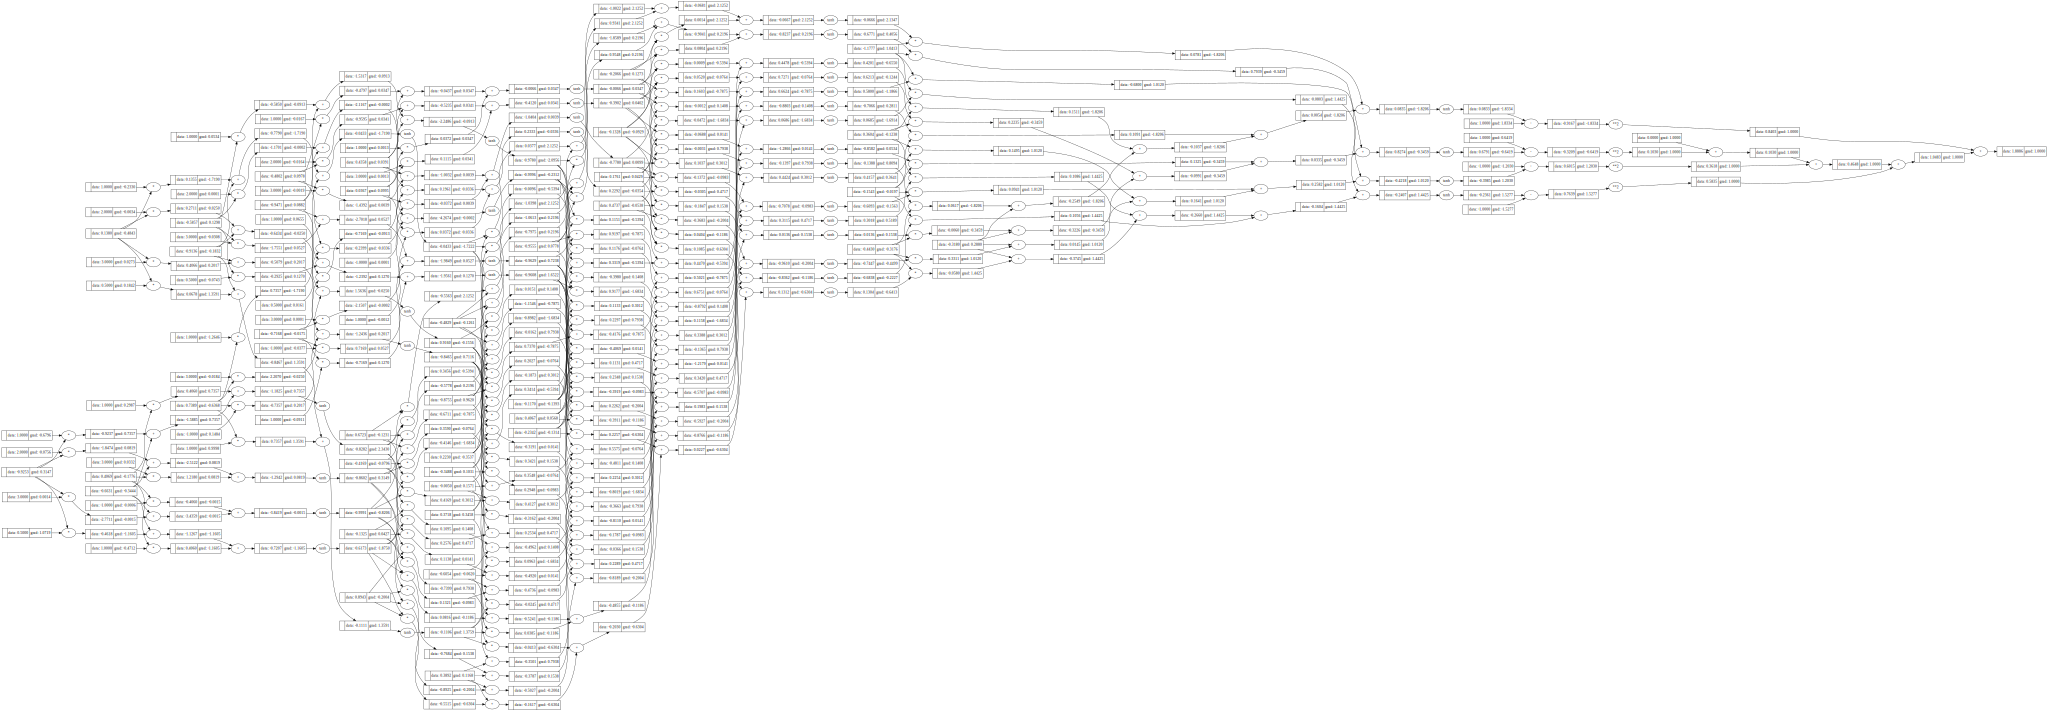

In [9]:
draw_dot(loss)